## Interactive audio sample cleaning

In [3]:
use_case = {
            'experiment' : 1,
            'project_root': '/home/olly/Desktop/Kaggle_BC25',
            #'project_root': r'C:\Users\ollyp\OneDrive\Desktop\Kaggle_BC25'
            #'project_root': '/media/olly/Red_SSD/Kaggle_BC25'
            }

In [4]:
import librosa
import time
from time import sleep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from glob import glob
from tqdm import tqdm
import torchaudio
import pickle
import matplotlib.animation as animation
import IPython.display as ipd
import torchaudio.transforms as T
from IPython.display import display, HTML, Audio  # Fixed deprecated import
import librosa.display
import time
import IPython.display as ipd
#from IPython.core.display import display, HTML

import ipywidgets as widgets
button = widgets.Button(description="Continue")
output = widgets.Output()

%matplotlib widget  
torch.set_num_threads(1)

In [5]:
class FilePaths:
    def __init__(self, options=None):
        _project_dir = Path(options['project_root'])
        self.DATA_FOLDER = _project_dir / 'Data'
        self.ORIGINAL_AUDIO = self.DATA_FOLDER / 'Original_Data/birdclef-2025/train_audio'
        self.KAGGLE_LABELS = self.DATA_FOLDER / 'Train_Metadata' / 'train.csv'
        self.CROP_LABELS = self.DATA_FOLDER / 'Train_Metadata' / 'marked_labels.parquet'
        self.OUTPUT_CSV_PATH = self.DATA_FOLDER / 'Train_Metadata/train.csv'
        self.OUTPUT_NAMING_CSV_PATH = self.DATA_FOLDER / 'Train_Metadata/naming.csv'
        self.OUTPUT_JSON_PATH = self.DATA_FOLDER / 'Train_Metadata/species_names.json'

paths = FilePaths(use_case)

In [6]:
class VoiceDetector():
    def __init__(self, chunk_len, threshold=0.1, no_voice=0, voice=20):
        model, (get_speech_timestamps, _, read_audio, _, _) = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                                                                 model='silero_vad', verbose=False)
        self.model=model
        self.chunk_len=chunk_len
        self.threshold=threshold
        self.get_stamps = get_speech_timestamps

    def detect(self, np_wav):
        speech_timestamps = self.get_stamps(torch.Tensor(np_wav), self.model, threshold=self.threshold)
        voice_detect = np.zeros_like(np_wav)
        for st in speech_timestamps:
            voice_detect[st['start']: st['end']] = 20
    
        #downsample to match the power plot axis
        voice_detect = np.pad(voice_detect, 
                            (0, int(np.ceil(len(voice_detect) / self.chunk_len) * self.chunk_len - len(voice_detect))))
        voice_detect = voice_detect.reshape((-1, self.chunk_len)).max(axis=1)  # Use max to preserve speech detection
        return voice_detect
    
def calc_signal_pwr(wav, chunk_len, sr=32000):
    power = wav ** 2 
    power = np.pad(power, (0, int(np.ceil(len(power) / chunk_len) * chunk_len - len(power))))
    power = power.reshape((-1, chunk_len)).sum(axis=1)
    return power

class MelSpecMaker():
    def __init__(self, sr=32000, n_mels=128, n_fft=2048, f_min = 20, f_max=14000):
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.f_min = f_min
        self.f_max = f_max
        self.mel_transform = T.MelSpectrogram(sample_rate=self.sr,
                                              n_mels=self.n_mels,
                                              f_min=self.f_min,
                                              f_max=self.f_max,
                                              n_fft=self.n_fft)

    def create_melspec(self, waveform):
        waveform = torch.tensor(waveform).unsqueeze(0)  #We need a channel-first Torch tensor
        mel_spec = self.mel_transform(waveform)
        mel_spec_db = torchaudio.functional.amplitude_to_DB(
            mel_spec, 
            multiplier=10.0, 
            amin=1e-10,  
            db_multiplier=0.0  
        ).squeeze(0).numpy()

        num_frames = mel_spec_db.shape[1]
        duration = waveform.shape[1] / self.sr 
        time_axis = np.linspace(0, duration, num=num_frames)
        mel_frequencies = librosa.mel_frequencies(n_mels=self.n_mels, fmin=20, fmax=14000)

        return mel_spec_db, time_axis, mel_frequencies

def interactive_plot(mel_spec_db,
                     mel_frequencies,
                     power,
                     segmentation,
                     chunk_duration,
                     common_nm,
                     zoo_cls):
    """Interactive plot with click-based marking, auto-spacing, and drag-to-mark functionality."""
    
    duration = len(power) * chunk_duration
    t_power = np.arange(len(power)) * chunk_duration
    t_seg = np.arange(len(segmentation)) * chunk_duration
    t_melspec = np.linspace(0, duration, num=mel_spec_db.shape[1])

    marked_times = []
    marked_lines = []
    dragging = False
    start_time = None
    
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.set_title(f'Recording of a {common_nm} ({zoo_cls})')

    img = ax.imshow(mel_spec_db, aspect='auto', origin='lower', cmap='magma',
                    extent=[t_melspec[0], t_melspec[-1], mel_frequencies[0], mel_frequencies[-1]],
                    zorder=1)

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)", color='m')
    ax.tick_params(axis='y', labelcolor='m')

    ax2 = ax.twinx()
    ax2.plot(t_power, 10 * np.log10(power), 'b', label='Power', zorder=2)  
    ax2.plot(t_seg, segmentation, 'k', label='Voice', zorder=2)
    ax2.set_ylabel("Power (dB) / Voice Detection", color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.legend(loc="upper right")

    def add_marker(time):
        if time not in marked_times:
            marked_times.append(time)
            line1 = ax.axvline(time - 6, color='gray', linestyle='--', zorder=3)
            line2 = ax.axvline(time + 6, color='gray', linestyle='--', zorder=3)
            area = ax.axvspan(time - 6, time + 6, color='gray', alpha=0.5)
            line3 = ax.axvline(time, color='g', linestyle='--', zorder=4)
            marked_lines.append((line1, line2, line3, area))
            fig.canvas.draw_idle()

    def onclick(event):
        nonlocal dragging, start_time
        if event.inaxes is not None and event.button == 1:
            dragging = True
            start_time = round(event.xdata, 1)
            add_marker(start_time)

    def onmotion(event):
        if dragging and event.inaxes is not None:
            current_time = round(event.xdata, 1)
            if current_time > start_time:
                time_offset = current_time - start_time
                next_marker = start_time + 12 * (time_offset // 12)
                if next_marker <= duration and next_marker not in marked_times:
                    add_marker(next_marker)

    def onclick(event):
        nonlocal dragging, start_time
        if event.inaxes is not None:
            if event.button == 1:  # Left click to add markers
                dragging = True
                start_time = round(event.xdata, 1)
                add_marker(start_time)
            elif event.button == 3:  # Right click to remove the most recent mark
                if marked_times:
                    marked_times.pop()
                    line_set = marked_lines.pop()
                    for line in line_set:
                        line.remove()
                    fig.canvas.draw_idle()

    def onrelease(event):
        nonlocal dragging
        if event.button == 1:
            dragging = False
    
    def onkeypress(event):
        if event.key == 'a':
            for line_set in marked_lines:
                for line in line_set:
                    line.remove()
            marked_lines.clear()
            marked_times.clear()
            
            end_buffer = 6
            start_buffer= 6
            max_spacing = 12
            time_to_cover = max(0, duration - start_buffer - end_buffer)
            num_spaces = time_to_cover // max_spacing + 1
            spacing = time_to_cover / num_spaces
            #spacing = time_to_cover/num_marks
            time = start_buffer
            while time <= (duration - end_buffer):
                add_marker(round(time,1))
                time += spacing
        elif event.key == ' ':  # Spacebar to clear all
            for line_set in marked_lines:
                for line in line_set:
                    line.remove()
            marked_lines.clear()
            marked_times.clear()
        
        fig.canvas.draw_idle()

    fig.canvas.mpl_connect('button_press_event', onclick)
    fig.canvas.mpl_connect('motion_notify_event', onmotion)
    fig.canvas.mpl_connect('button_release_event', onrelease)
    fig.canvas.mpl_connect('key_press_event', onkeypress)

    plt.show()
    return marked_times





def mark_one_sample(filename, common_nm, zoo_cls):
    wav, sr = librosa.load(filename, sr=None)  #returns a mono-channel NumPy array
    chunk_duration = 0.1
    chunk_len  = int(chunk_duration * sr)
    specmaker = MelSpecMaker(sr=sr)
    voice_detector = VoiceDetector(chunk_len)
    mel_spec_db, time_axis, mel_frequencies = specmaker.create_melspec(wav)
    power = calc_signal_pwr(wav, chunk_len)
    voice_detections = voice_detector.detect(wav)
    # Set the audio player width to match the plot width
    display(HTML("<style>audio { width: 800px; margin-left: 35px; }</style>"))
    display(ipd.Audio(filename)) 
    marked_times = interactive_plot(mel_spec_db,
                                    mel_frequencies,
                                    power,
                                    voice_detections,
                                    chunk_duration,
                                    common_nm=common_nm,
                                    zoo_cls=zoo_cls,)
    return marked_times

def plot_duration_mix(df, threshold):
    df['duration_category'] = df['duration'].apply(lambda x: f'< {threshold} s' if x < threshold else f'> {threshold} s')
    df_counts = df.groupby(['primary_label', 'duration_category']).size().reset_index(name='count')
    df_counts = df_counts.sort_values(by='count', ascending=False)
    custom_colors = {f'< {threshold} s': 'blue', f'> {threshold} s': 'red'}

    fig = px.bar(
        df_counts, 
        x="primary_label", 
        y="count", 
        color="duration_category",
        title="Stacked Occurrences by Duration",
        labels={"duration_category": "Duration", "count": "Occurrences", "primary_label": "Label"},
        barmode="stack",
        color_discrete_map=custom_colors,
        opacity=1.0  # Ensure full opacity
    )
    fig.show()

## Process Kaggle Samples
Start by loading the auxiliary dataframe parquet with a 'duration' column produce by the EDA notebook

In [7]:
df = pd.read_parquet(paths.CROP_LABELS, engine="pyarrow")
df.head(3)

,filename,primary_label,collection,author,common_name,class,secondary_labels,duration,centres,date_reviewed
0,528041/CSA36365.ogg,528041,CSA,Fabio A. Sarria-S,Orophus conspersus,insecta,[''],112.417563,[4.1],2025-03-30 17:26:38.846914
1,528041/CSA36359.ogg,528041,CSA,Fabio A. Sarria-S,Orophus conspersus,insecta,[''],101.033469,[4.1],2025-03-30 17:26:52.355833
2,1139490/CSA36385.ogg,1139490,CSA,Fabio A. Sarria-S,Ragoniella pulchella,insecta,[''],98.853375,[4.0],2025-03-30 17:27:03.258653


Let's look at the frequency of the duration column

In [8]:
import plotly.express as px

fig = px.histogram(df, x='duration', nbins=30)
fig.update_layout(title='Histogram of Duration', xaxis_title='Duration', yaxis_title='Frequency')
fig.show()

In [9]:
bins = [5, 10, 12, 20, 30, 40, 60, 120]
counts = [(df['duration'] > b).sum() for b in bins]
df_counts = pd.DataFrame({'Duration Threshold': bins, 'Count > Threshold': counts})
fig = px.line(df_counts, x='Duration Threshold', y='Count > Threshold', markers=True, title='Reverse Cumulative Histogram of Duration')
fig.update_layout(xaxis_title='Duration', yaxis_title='Count of Values > Threshold')
fig.show()

So in total we have 20,255 samples with length over 12 seconds.  Let's take a closer look at a few of these rows

In [10]:
df = df.sort_values(by='duration', ascending=False)
df.head(15)

,filename,primary_label,collection,author,common_name,class,secondary_labels,duration,centres,date_reviewed
10495,yercac1/XC245490.ogg,yercac1,XC,Oscar Humberto Marín Gómez,Yellow-rumped Cacique,aves,"['cotfly1', 'pirfly1', 'yebela1', 'cargra1', '...",1774.392000,[],NaT
18933,compau/XC837459.ogg,compau,XC,Fernanda Fernandex,Common Pauraque,aves,['trsowl'],1509.988750,[],NaT
5612,greegr/XC558126.ogg,greegr,XC,Thomas G. Graves,Great Egret,aves,[''],1255.056000,"[6.0, 18.0, 29.9, 41.9, 53.8, 65.8, 77.7, 89.7...",2025-04-10 16:19:20.937626
13904,saffin/XC879442.ogg,saffin,XC,Fernanda Fernandex,Saffron Finch,aves,[''],1076.904000,[],NaT
6359,stbwoo2/XC709416.ogg,stbwoo2,XC,Richard E. Webster,Straight-billed Woodcreeper,aves,"['greibi1', 'creoro1', 'whtdov', 'strfly1', 'g...",1020.048000,[],NaT
7944,speowl1/XC525219.ogg,speowl1,XC,Mauricio Álvarez-Rebolledo,Spectacled Owl,aves,[''],1010.364094,[],NaT
5852,colcha1/XC716579.ogg,colcha1,XC,Hernán Arias,Colombian Chachalaca,aves,[''],963.395000,[],NaT
19583,grekis/XC936081.ogg,grekis,XC,Fernanda Fernandex,Great Kiskadee,aves,['bobfly1'],946.128000,[],NaT
19584,grekis/XC936811.ogg,grekis,XC,Fernanda Fernandex,Great Kiskadee,aves,['trokin'],935.064000,[],NaT
112,52884/CSA18804.ogg,52884,CSA,Orlando Acevedo-Charry,True Crickets,insecta,[''],896.575094,"[41.0, 53.0, 65.0, 77.0, 89.0, 101.0, 113.0, 1...",2025-03-31 08:46:12.127564


Let's get a new column with the count by primary label for later filtering.

In [11]:
df['label_count'] = df.groupby('primary_label')['primary_label'].transform('count')
df.head()

,filename,primary_label,collection,author,common_name,class,secondary_labels,duration,centres,date_reviewed,label_count
10495,yercac1/XC245490.ogg,yercac1,XC,Oscar Humberto Marín Gómez,Yellow-rumped Cacique,aves,"['cotfly1', 'pirfly1', 'yebela1', 'cargra1', '...",1774.39200,[],NaT,255
18933,compau/XC837459.ogg,compau,XC,Fernanda Fernandex,Common Pauraque,aves,['trsowl'],1509.98875,[],NaT,650
5612,greegr/XC558126.ogg,greegr,XC,Thomas G. Graves,Great Egret,aves,[''],1255.05600,"[6.0, 18.0, 29.9, 41.9, 53.8, 65.8, 77.7, 89.7...",2025-04-10 16:19:20.937626,120
13904,saffin/XC879442.ogg,saffin,XC,Fernanda Fernandex,Saffron Finch,aves,[''],1076.90400,[],NaT,332
6359,stbwoo2/XC709416.ogg,stbwoo2,XC,Richard E. Webster,Straight-billed Woodcreeper,aves,"['greibi1', 'creoro1', 'whtdov', 'strfly1', 'g...",1020.04800,[],NaT,129


In [12]:
#common_df = df[df['label_count'] >= 400]
df_gt_100 = df[df['label_count'] >= 100].copy()
df_lt_100 = df[df['label_count'] <= 100].copy()
df_lt_120 = df[df['label_count'] <= 120].copy()
#df = df[(df['label_count'] <=500) | (df['duration'] <= 12)]
df.head()

,filename,primary_label,collection,author,common_name,class,secondary_labels,duration,centres,date_reviewed,label_count
10495,yercac1/XC245490.ogg,yercac1,XC,Oscar Humberto Marín Gómez,Yellow-rumped Cacique,aves,"['cotfly1', 'pirfly1', 'yebela1', 'cargra1', '...",1774.39200,[],NaT,255
18933,compau/XC837459.ogg,compau,XC,Fernanda Fernandex,Common Pauraque,aves,['trsowl'],1509.98875,[],NaT,650
5612,greegr/XC558126.ogg,greegr,XC,Thomas G. Graves,Great Egret,aves,[''],1255.05600,"[6.0, 18.0, 29.9, 41.9, 53.8, 65.8, 77.7, 89.7...",2025-04-10 16:19:20.937626,120
13904,saffin/XC879442.ogg,saffin,XC,Fernanda Fernandex,Saffron Finch,aves,[''],1076.90400,[],NaT,332
6359,stbwoo2/XC709416.ogg,stbwoo2,XC,Richard E. Webster,Straight-billed Woodcreeper,aves,"['greibi1', 'creoro1', 'whtdov', 'strfly1', 'g...",1020.04800,[],NaT,129


In [13]:
bins = [5, 10, 12, 20, 30, 40, 60, 120]
counts = [(df['duration'] > b).sum() for b in bins]

df_counts = pd.DataFrame({'Duration Threshold': bins, 'Count > Threshold': counts})

fig = px.line(df_counts, x='Duration Threshold', y='Count > Threshold', markers=True, title='Reverse Cumulative Histogram of Duration')
fig.update_layout(xaxis_title='Duration', yaxis_title='Count of Values > Threshold')
fig.show()

In [14]:
counts

[20255, 20255, 20255, 14869, 10330, 7462, 4282, 1226]

In [15]:
#filtered_df = df[df['label_count'] < 100]
duration_counts = df_lt_100.groupby('primary_label')['duration'].apply(lambda x: (x > 12).sum()).reset_index()
duration_counts.columns = ['primary_label', 'count_over_12']

fig = px.bar(duration_counts, x='primary_label', y='count_over_12', 
             title='Count of Samples with Duration > 12 for Labels with < 100 Total Samples',
             labels={'primary_label': 'Primary Label', 'count_over_12': 'Count of Duration > 12'},
             text='count_over_12')

fig.update_layout(xaxis={'categoryorder':'total ascending'}, xaxis_tickangle=-45)
fig.show()


In [16]:
len(df_lt_100)

4399

In [17]:
len(df_lt_120)

5852

In [18]:
df_lt_100['primary_label'].nunique()

134

In [19]:
df_lt_120['primary_label'].nunique()

147

So if I marked up all 4,159 samples from classes rarest first I would have 118 classes fully marked with up to 100 samples.  The question is what to do with the rest of the classes.  What proportion of these are over 12 seconds?

In [20]:
df_gt_100.head()

,filename,primary_label,collection,author,common_name,class,secondary_labels,duration,centres,date_reviewed,label_count
10495,yercac1/XC245490.ogg,yercac1,XC,Oscar Humberto Marín Gómez,Yellow-rumped Cacique,aves,"['cotfly1', 'pirfly1', 'yebela1', 'cargra1', '...",1774.39200,[],NaT,255
18933,compau/XC837459.ogg,compau,XC,Fernanda Fernandex,Common Pauraque,aves,['trsowl'],1509.98875,[],NaT,650
5612,greegr/XC558126.ogg,greegr,XC,Thomas G. Graves,Great Egret,aves,[''],1255.05600,"[6.0, 18.0, 29.9, 41.9, 53.8, 65.8, 77.7, 89.7...",2025-04-10 16:19:20.937626,120
13904,saffin/XC879442.ogg,saffin,XC,Fernanda Fernandex,Saffron Finch,aves,[''],1076.90400,[],NaT,332
6359,stbwoo2/XC709416.ogg,stbwoo2,XC,Richard E. Webster,Straight-billed Woodcreeper,aves,"['greibi1', 'creoro1', 'whtdov', 'strfly1', 'g...",1020.04800,[],NaT,129


In [21]:
plot_duration_mix(df_gt_100, 20)

secfly1, strher & snoegr could be double in size if their long samples were included, and they only have approx 50 short samples.  But for the rest, the long samples could sensibly be filtered out for the purpose of having a clean dataset, and the loss of data would be small.  This should be tried as an experiment.

Or maybe we throw away anything over 30 seconds?  A bit less clean, but a bit more data?   Or over 30 seconds up until there are 200 samples, then over 20 seconds up to 300 samples, then anything over 12 seconds after that?

In [22]:
plot_duration_mix(df_gt_100, 30)

#### Marking Strategy
- Mark all 26 of Fabio Sierra's first, since they have a consistant voice-sample format
- Mark the remaining 118 CSA samples
- Mark the 4159 samples from the rarest 120 or so classes.
- Mark as many of the remaining 17,000 samples over 12 seconds as I can, from rarest first.
- Throw away any remaining samples over 20 seconds, and experiment later with a progressive duration/counts approach for this.

In [23]:
df.head()

,filename,primary_label,collection,author,common_name,class,secondary_labels,duration,centres,date_reviewed,label_count
10495,yercac1/XC245490.ogg,yercac1,XC,Oscar Humberto Marín Gómez,Yellow-rumped Cacique,aves,"['cotfly1', 'pirfly1', 'yebela1', 'cargra1', '...",1774.39200,[],NaT,255
18933,compau/XC837459.ogg,compau,XC,Fernanda Fernandex,Common Pauraque,aves,['trsowl'],1509.98875,[],NaT,650
5612,greegr/XC558126.ogg,greegr,XC,Thomas G. Graves,Great Egret,aves,[''],1255.05600,"[6.0, 18.0, 29.9, 41.9, 53.8, 65.8, 77.7, 89.7...",2025-04-10 16:19:20.937626,120
13904,saffin/XC879442.ogg,saffin,XC,Fernanda Fernandex,Saffron Finch,aves,[''],1076.90400,[],NaT,332
6359,stbwoo2/XC709416.ogg,stbwoo2,XC,Richard E. Webster,Straight-billed Woodcreeper,aves,"['greibi1', 'creoro1', 'whtdov', 'strfly1', 'g...",1020.04800,[],NaT,129


In [24]:
len(df)

20255

In [25]:
df=df[df['duration'] > 12]
len(df)

20255

In [26]:
df['sort_csa'] = df['collection'].eq('CSA')  # True if 'csa', else False
df['sort_fabio'] = df['author'].eq('Fabio A. Sarria-S')  # True if 'Fabio', else False
df = df.sort_values(by=[ 'sort_fabio', 'sort_csa','label_count',], ascending=[False, False, True])
df = df.drop(columns=['label_count', 'sort_csa', 'sort_fabio']).reset_index(drop=True)
if 'centres' not in df.columns:
    df['centres'] = [[] for _ in range(len(df))]
if 'date_reviewed' not in df.columns:
    df['date_reviewed'] = pd.NaT  # Assigns missing datetime values
df.head(3)

,filename,primary_label,collection,author,common_name,class,secondary_labels,duration,centres,date_reviewed
0,528041/CSA36365.ogg,528041,CSA,Fabio A. Sarria-S,Orophus conspersus,insecta,[''],112.417563,[4.1],2025-03-30 17:26:38.846914
1,528041/CSA36359.ogg,528041,CSA,Fabio A. Sarria-S,Orophus conspersus,insecta,[''],101.033469,[4.1],2025-03-30 17:26:52.355833
2,1139490/CSA36385.ogg,1139490,CSA,Fabio A. Sarria-S,Ragoniella pulchella,insecta,[''],98.853375,[4.0],2025-03-30 17:27:03.258653


In [27]:
df.tail(3)

,filename,primary_label,collection,author,common_name,class,secondary_labels,duration,centres,date_reviewed
20252,grekis/iNat1102480.ogg,grekis,iNat,Bodo Nuñez Oberg,Great Kiskadee,aves,[''],12.024000,[],NaT
20253,grekis/XC127206.ogg,grekis,XC,Oswaldo Cortes,Great Kiskadee,aves,[''],12.016312,[],NaT
20254,grekis/iNat892500.ogg,grekis,iNat,Jon McIntyre,Great Kiskadee,aves,[''],12.003250,[],NaT


In [28]:
reviewed = df[~df['date_reviewed'].isna()].reset_index(drop=True).copy()
not_reviewed = df[df['date_reviewed'].isna()].reset_index(drop=True).copy()

In [29]:
not_reviewed.head(3)

,filename,primary_label,collection,author,common_name,class,secondary_labels,duration,centres,date_reviewed
0,greegr/XC193153.ogg,greegr,XC,Paul Marvin,Great Egret,aves,[''],245.376000,[],NaT
1,greegr/XC161279.ogg,greegr,XC,Paul Marvin,Great Egret,aves,"['rosspo1', 'woosto']",230.544000,[],NaT
2,strowl1/XC393840.ogg,strowl1,XC,Dan Lane,Striped Owl,aves,['compot1'],195.160812,[],NaT


/home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/greegr/XC193153.ogg
Secondary Labels: ['']


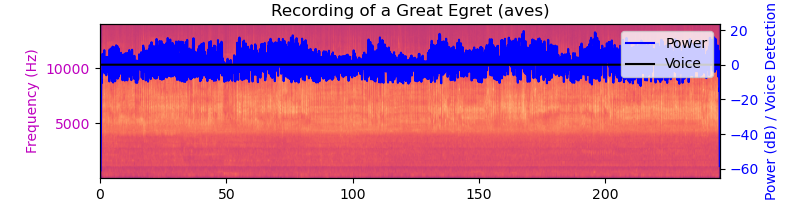

In [30]:
#print(f"Processing row with primary_label: {not_reviewed.at[0,'primary_label']}")
filepath = paths.ORIGINAL_AUDIO / not_reviewed.at[0,'filename'] #.iloc[0]
print(filepath)
common_name = not_reviewed.at[0, 'common_name']
zoo_class =  not_reviewed.at[0, 'class']
secondary = not_reviewed.at[0, 'secondary_labels']
print(f'Secondary Labels: {secondary}')
logged = False
marked_times = False
marked_times = mark_one_sample(filepath, common_name, zoo_class)

In [31]:
if marked_times and not logged:
    not_reviewed.at[0, 'centres'] = marked_times
    not_reviewed.at[0, 'date_reviewed'] = pd.Timestamp.now()
    reviewed = pd.concat([reviewed, not_reviewed.iloc[[0]]], ignore_index=True)
    not_reviewed = not_reviewed.iloc[1:].reset_index(drop=True)  # Drop first row and reset index
    updated_df = pd.concat([reviewed, not_reviewed], ignore_index=True)
    updated_df.to_parquet(paths.CROP_LABELS, engine="pyarrow")
    print(f'The following time centres getting added: {marked_times}')
    plt.close()
    logged=True

In [32]:
reviewed.tail(1)

,filename,primary_label,collection,author,common_name,class,secondary_labels,duration,centres,date_reviewed
5613,strowl1/XC577721.ogg,strowl1,XC,JAYRSON ARAUJO DE OLIVEIRA,Striped Owl,aves,[''],350.955094,"[6.0, 17.7, 29.4, 41.1, 52.8, 64.4, 76.1, 87.8...",2025-04-10 16:19:39.394977


rejects:  
cargra1/iNat969137.ogg  
41663/iNat181697.ogg  (actually I think it's the one after this, a racoon)  
41663/iNat1187502.ogg  
41663/iNat1001216.ogg  
gybmar/XC277037.ogg  
babwar/iNat399853.ogg
babwar/iNat247468.ogg